In [3]:
# !pip install openai
# !pip install Levenshtein
# !pip install seaborn
# !pip install sentence_transformers

In [4]:
import pandas as pd
import json
import re
from ast import literal_eval

In [5]:
from tqdm import tqdm

In [6]:
with open('data/silver_50x3.json', 'r') as file1, \
    open('data/silver_112x3.json', 'r') as file2, open('data/gold_40_plus_10x4.json', 'r') as file3:
  silver50 = json.load(file1)
  silver112 = json.load(file2)
  gold40 = json.load(file3)

In [7]:
pair2args = {}

for i in range(len(silver50)):
    pair2args[(silver50[i]['object1'], silver50[i]['object2'])] = silver50[i]['arguments']

In [8]:
with open('data/dataset_cqa_all_gpt.json', 'r') as file1:
  relevance = json.load(file1)

relevance = dict(map(lambda x: (tuple(sorted((x['obj1'], x['obj2']))), x['arguments']), relevance))

In [9]:
import numpy as np

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

def split_text2args(text):
    return re.findall(r"([A-Z].+?)\[(.+?)\]", text)

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [11]:
from Levenshtein import distance

distance("I have a phone".split(), "I have a".split())

1

In [12]:
metrics = {
    'gs': {'jac_text': [], 'jac_sent': [], 'lev_sent': [], 'bert_text': [], 'bert_sent': [],
           'pr': [], 'rec': [], 'f1': [], 'aac': []},
    's':  {'jac_text': [], 'jac_sent': [], 'lev_sent': [], 'bert_text': [], 'bert_sent': [],
           'pr': [], 'rec': [], 'f1': [], 'aac': []},
    'g':  {'jac_text': [], 'jac_sent': [], 'lev_sent': [], 'bert_text': [], 'bert_sent': [],
           'pr': [], 'rec': [], 'f1': [], 'aac': []}
}

## Compute Jaccard, Levenstein, BERT similarity

In [13]:
def convert(lst):
    return literal_eval(lst)

def compute_metrics_text(pair):
    if len(pair['arguments']) > 0:
        args = " ".join(pair['arguments'])
        sims = []
        berts = []
        for text in pair['gpt_answers']:
            sims.append(jaccard_similarity(args.split(), text.split()))
            embedding_1 = model.encode(args, convert_to_tensor=True)
            embedding_2 = model.encode(text, convert_to_tensor=True)
            berts.append(util.pytorch_cos_sim(embedding_1, embedding_2))
        return sims, berts
    else:
        return [], []

def compute_metrics_sentence(pair):
    if len(pair['arguments']) > 0:
        sims = []
        levs = []
        berts = []
        for text in pair['gpt_answers']:
            for argument, ids in split_text2args(text):
                sims.append(max([jaccard_similarity(arg.split()[1:], argument.split()) for arg in pair['arguments']]))
                levs.append(min([distance(arg.split()[1:], argument.split()) for arg in pair['arguments']]))
                berts.append(max([util.pytorch_cos_sim(model.encode(arg, convert_to_tensor=True), model.encode(argument, convert_to_tensor=True)) for arg in pair['arguments']]))

        return sims, levs, berts
    else:
        return [],[], []


In [ ]:
from tqdm import tqdm
import numpy as np

def process_pairs(pairs, key, inject_args=False):
    for pair in tqdm(pairs):
        if inject_args:
            pair['arguments'] = pair2args[(pair['object1'], pair['object2'])]
            pair['gpt_answers'] = pair['comparison']

        sims_text, berts_text = compute_metrics_text(pair)
        metrics[key]['jac_text'].extend(sims_text)
        metrics[key]['bert_text'].extend(berts_text)

        sims_sent, levs_sent, berts_sent = compute_metrics_sentence(pair)
        metrics[key]['jac_sent'].extend(sims_sent)
        metrics[key]['lev_sent'].extend(levs_sent)
        metrics[key]['bert_sent'].extend(berts_sent)

# Process each dataset
process_pairs(silver50, key='gs')
process_pairs(silver112, key='s')
process_pairs(gold40, key='g', inject_args=True)

100%|██████████| 50/50 [05:25<00:00,  6.52s/it]


In [ ]:
def print_formatted_scores(metrics):
    print(f"{'Dataset Name':<25} {'Size':<6} {'Questions':<10} {'Jaccard_text':<14} {'Jaccard_sent':<14} {'Levenstein':<12} {'S-BERT':<8}")

    def row(label, size, questions, key):
        print(f"{label:<25} {size:<6} {questions:<10} "
              f"{np.mean(metrics[key]['jac_text']):<14.2f} "
              f"{np.mean(metrics[key]['jac_sent']):<14.2f} "
              f"{np.mean(metrics[key]['lev_sent']):<12.2f} "
              f"{np.mean(metrics[key]['bert_sent']):<8.2f}")

    row("Gold (human)", 80, 50, 'g')
    row("Silver (subset) (ChatGPT)", 150, 50, 'gs')
    row("Silver (ChatGPT)", 336, 112, 's')

print_formatted_scores(metrics)

Dataset Name              Size   Questions  Jaccard_text   Jaccard_sent   Levenstein   S-BERT  
Gold (human)              80     50         0.14           0.18           20.53        0.68    
Silver (subset) (ChatGPT) 150    50         0.24           0.21           11.88        0.69    
Silver (ChatGPT)          336    112        0.25           0.21           11.82        0.68    


## Compute ChatGPT metrics

In [59]:
import os
os.environ["OPENAI_API_KEY"] =''

In [ ]:
from openai import OpenAI
import os

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

def get_ac_score(text1, text2):
    content = f"""You are given two sentences, the task is check whether the second derives from the first one and does not contradict. Return 1 if the second derives from the first one and does not contradict, 0 otherwise.
    ANSWER ONLY WITH A NUMBER!
    Examples:
    text1: cats are smarter than dogs
    text2: cats are more intelligent than dogs
    answer: 1

    text1: cats are smarter than dogs
    text2: dogs are more intelligent than cats
    answer: 0

    text1: cats are smarter than dogs
    text2: cats are more elegant than dogs
    answer: 0


    text1: {text1}
    text2: {text2}
    answer:
    """


    completion = client.chat.completions.create(model="gpt-4o-mini",
          messages=[
                {"role": "system", "content": "You are a helpful assistant in logic."},
                {"role": "user", "content": content}
            ], n=1
    )

    result_text = completion.choices[0].message.content
    return result_text

### compute AR and ChatGPTScores

In [ ]:
def get_relevant_ids(pair):
    """Get IDs of relevant arguments from the reference."""
    key = (pair['object1'], pair['object2'])
    reverse_key = (pair['object2'], pair['object1'])
    relevant_args = relevance.get(key, relevance.get(reverse_key, ''))

    if not relevant_args:
        return set()

    relevant_texts = [arg['argument'] for arg in relevant_args if arg['relevance'] >= 2]
    return {
        int(arg.split('. ')[0])
        for arg in pair['arguments']
        if arg.split('. ')[1] in relevant_texts
    }


def map_id_to_argument(pair):
    """Create a mapping from ID to argument text."""
    return dict(arg.split('. ', 1) for arg in pair['arguments'])


def parse_argument_ids(ids_str):
    """Extract integer IDs from a string representing IDs (including ranges)."""
    ids_int = []
    try:
        ids_int = [int(i.replace(' generated', '')) for i in ids_str.split(', ')]
    except:
        if '-' in ids_str:
            for part in ids_str.split(', '):
                if '-' in part:
                    start, end = map(int, part.split('-'))
                    ids_int.extend(range(start, end + 1))
        elif ' ' not in ids_str and 'generated' not in ids_str and ids_str != 'Paris':
            ids_int = [int(i) for i in ids_str.split(',')]
    return ids_int


def score_arguments(argument_pairs, id2arg):
    """Score argument pairs and collect argument IDs and AC scores."""
    all_ids = set()
    scores = []

    for argument, ids_str in argument_pairs:
        ids = parse_argument_ids(ids_str)
        all_ids.update(ids)

        for i in ids:
            arg_text = id2arg.get(str(i), '')
            if arg_text:
                ac_score_str = get_ac_score(arg_text, argument)
                score = int(p.findall(ac_score_str)[-1])
                scores.append(score)

    return all_ids, scores


def compute_single_answer_metrics(gpt_answer, id2arg, relevant_ids):
    """Compute precision, recall, F1, and AC for one GPT answer."""
    argument_pairs = split_text2args(gpt_answer)
    all_ids, scores = score_arguments(argument_pairs, id2arg)

    if not all_ids:
        return None

    overlap = all_ids.intersection(relevant_ids)
    precision = len(overlap) / len(all_ids)
    recall = len(overlap) / len(relevant_ids)
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    ac = sum(scores) / len(scores) if scores else 0

    return precision, recall, f1_score, ac


def compute_relevance(pair):
    """Main function to compute relevance-based metrics for a QA pair."""
    if not pair.get('arguments'):
        return [], [], [], []

    relevant_ids = get_relevant_ids(pair)
    if not relevant_ids:
        return [], [], [], []

    id2arg = map_id_to_argument(pair)

    precisions, recalls, f1_scores, acs = [], [], [], []

    for gpt_answer in pair['gpt_answers']:
        metrics = compute_single_answer_metrics(gpt_answer, id2arg, relevant_ids)
        if metrics:
            pr, rec, f1, ac = metrics
            precisions.append(pr)
            recalls.append(rec)
            f1_scores.append(f1)
            acs.append(ac)

    return precisions, recalls, f1_scores, acs

In [ ]:
def process_pairs(pairs, key, inject_args=False):
    for pair in tqdm(pairs):
        if inject_args:
            pair['arguments'] = pair2args[(pair['object1'], pair['object2'])]
            pair['gpt_answers'] = pair['comparison']

        pr, rec, f1, ac = compute_relevance(pair)
        metrics[key]['pr'].extend(pr)
        metrics[key]['rec'].extend(rec)
        metrics[key]['f1'].extend(f1)
        metrics[key]['aac'].extend(ac)

# Step 3: Run the data
process_pairs(silver50, key='gs')
process_pairs(silver112, key='s')
process_pairs(gold40, key='g', inject_args=True)

In [ ]:
# Step 4: Print in the formatted table
def print_formatted_scores(metrics):
    print(f"{'Dataset Name':<28} {'Size':<6} {'Questions':<10} "
          f"{'Jaccard_text':<14} {'Jaccard_sent':<14} {'Levenstein':<12} {'S-BERT':<8} "
          f"{'Pr_AR':<8} {'R_AR':<8} {'F1_AR':<8} {'AAC':<8}")

    def row(label, size, questions, key):
        print(f"{label:<28} {size:<6} {questions:<10} "
              f"{np.mean(metrics[key]['jac_text']):<14.2f} "
              f"{np.mean(metrics[key]['jac_sent']):<14.2f} "
              f"{np.mean(metrics[key]['lev_sent']):<12.2f} "
              f"{np.mean(metrics[key]['bert_sent']):<8.2f} "
              f"{np.mean(metrics[key]['pr']):<8.2f} "
              f"{np.mean(metrics[key]['rec']):<8.2f} "
              f"{np.mean(metrics[key]['f1']):<8.2f} "
              f"{np.mean(metrics[key]['aac']):<8.2f}")

    row("Gold (human)", 80, 50, 'g')
    row("Silver (subset) (ChatGPT)", 150, 50, 'gs')
    row("Silver (ChatGPT)", 336, 112, 's')

print_formatted_scores(metrics)

Dataset Name                 Size   Questions  Jaccard_text   Jaccard_sent   Levenstein   S-BERT   Pr_AR    R_AR     F1_AR    AAC     
Gold (human)                 80     50         nan            nan            nan          nan      nan      nan      nan      nan     
Silver (subset) (ChatGPT)    150    50         nan            nan            nan          nan      0.96     0.86     0.89     0.79    
Silver (ChatGPT)             336    112        nan            nan            nan          nan      0.95     0.83     0.87     0.78    


/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


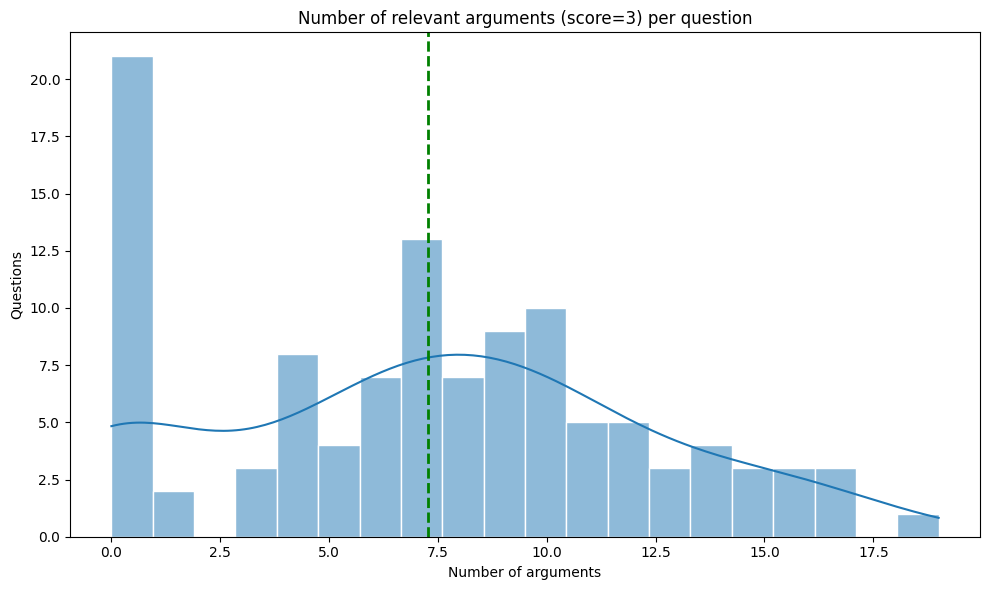

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

data = pd.read_json(r"data/silver_112x3.json")
data = data[["arguments"]].copy()
data["arguments"] = data["arguments"].apply(lambda l: len(l))

data = data[data["arguments"] <= 20]
np.random.seed(42)

plt.figure(figsize=(10, 6))
sns.histplot(data, bins=20, kde=True, color='skyblue', edgecolor='white', legend=False)
mean_val = np.mean(data["arguments"])
plt.axvline(mean_val, color='green', linestyle='--', linewidth=2)

plt.title("Number of relevant arguments (score=3) per question")
plt.xlabel("Number of arguments")
plt.ylabel("Questions")

plt.tight_layout()
plt.show()

In [34]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
from collections import defaultdict


pair2sums = defaultdict(lambda: defaultdict(list))

# Store 7x7 matrices for each entry
similarity_matrices = []

for item in gold40:
    if len(item['comparison']) == 4:
        pair2sums[(item['object1'], item['object1'])]['human'].extend(item['comparison'])

for item in silver50:
    if (item['object1'], item['object1']) in pair2sums.keys():
        pair2sums[(item['object1'], item['object1'])]['gpt'].extend(item['gpt_answers'])

for pair in tqdm(pair2sums):
    human_ = pair2sums[pair]['human']
    gpt_ = pair2sums[pair]['gpt']

    embeddings = model.encode(human_+gpt_, convert_to_tensor=True)

    sim_matrix = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()

    similarity_matrices.append(sim_matrix)


100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


In [40]:
import matplotlib.pyplot as plt
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

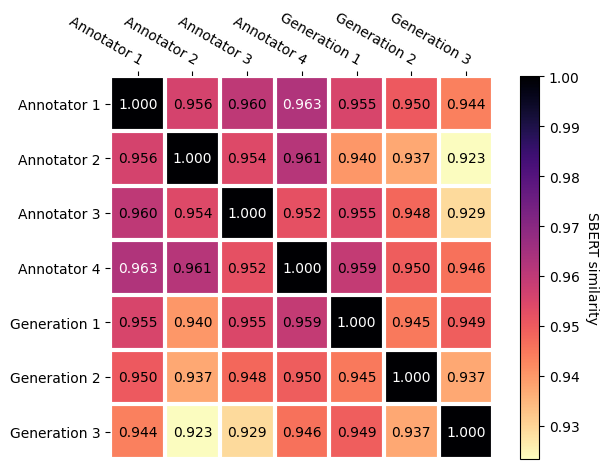

In [41]:
fig, ax = plt.subplots()
mean_similarity = np.mean(similarity_matrices, axis=0)
labels = [f"Annotator {i+1}" for i in range(4)] + [f"Generation {i+1}" for i in range(3)]

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels)), labels=labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

im, cbar = heatmap(mean_similarity, labels, labels, ax=ax,
                   cmap="magma_r", cbarlabel="SBERT similarity")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.savefig("heatmap.pdf", dpi=1000)